
<h3 style="text-align: center;"><b>Homework. Fully connected and convolutional neural networks</b></h3>

In this lesson you will practice building neural networks using the Pytorch library. We will do this on several datasets.







In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Part 1. Moons dataset (50 Points)

Let's generate a dataset and take a look at it!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Let's do a train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Loading data
In PyTorch, loading data usually happens on the fly (sometimes datasets do not fit into RAM). Two entities `Dataset` and `DataLoader` are used for this.

1. `Dataset` loads each object separately.

2. `DataLoader` groups objects from `Dataset` into batches.

Since our dataset is quite small, we will use `TensorDataset`. All we need is to convert from a numpy array to a tensor with the `torch.float32` type.

### Task. Create tensors with training and test data

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

Create `Dataset` and `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Reminder**
Let's review what happens in logistic regression. At the input, we have a feature matrix X and a column vector $y$ - the labels from $\{0, 1\}$ for each feature. We want to find a weight matrix $W$ and a bias $b$ such that our model $XW + b$ will somehow predict the class of the feature. As you can see, our model can output a number in the range of $(-\infty;\infty)$. This output is usually called "logits". We need to translate it to the range of $[0;1]$ so that it gives us the probability of the feature belonging to class one, it is also better for this function to be monotone, quickly calculated, have a derivative and have a value of $0$ on $-\infty$ and a value of $1$ on $+\infty$. This class of functions is called a sigmoid. Most often, the sigmoid is taken as
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Task. Implementation of logistic regression

You need to write a module in PyTorch implementing $logits = XW + b$, where $W$ and $b$ are parameters (`nn.Parameter`) of the model. In other words, here we will implement the `nn.Linear` module ourselves (its use is prohibited in this section). Initialize the weights with a normal distribution (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Question 1.** How many trainable parameters does the resulting model have?


This refers to the total number of individual numerical variables, not the number of tensors.

In [ ]:
total_params = sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 3


### Train loop

Here's some pseudocode to help you understand what's going on during training.

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

The code below adds logging of `accuracy` and `loss`.

### Task. Implementation of the learning cycle



In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch.unsqueeze(1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.375
Iteration: 100
Batch accuracy: 0.828125
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.9140625
Iteration: 600
Batch accuracy: 0.8828125

Iteration: 637.Convergence. Stopping iterations.


**Question 2.** How many iterations did it take for the algorithm to converge?

**Answer:**

**Question 2.** How many iterations did it take for the algorithm to converge?

**Answer:** 637

### Visualizing the results



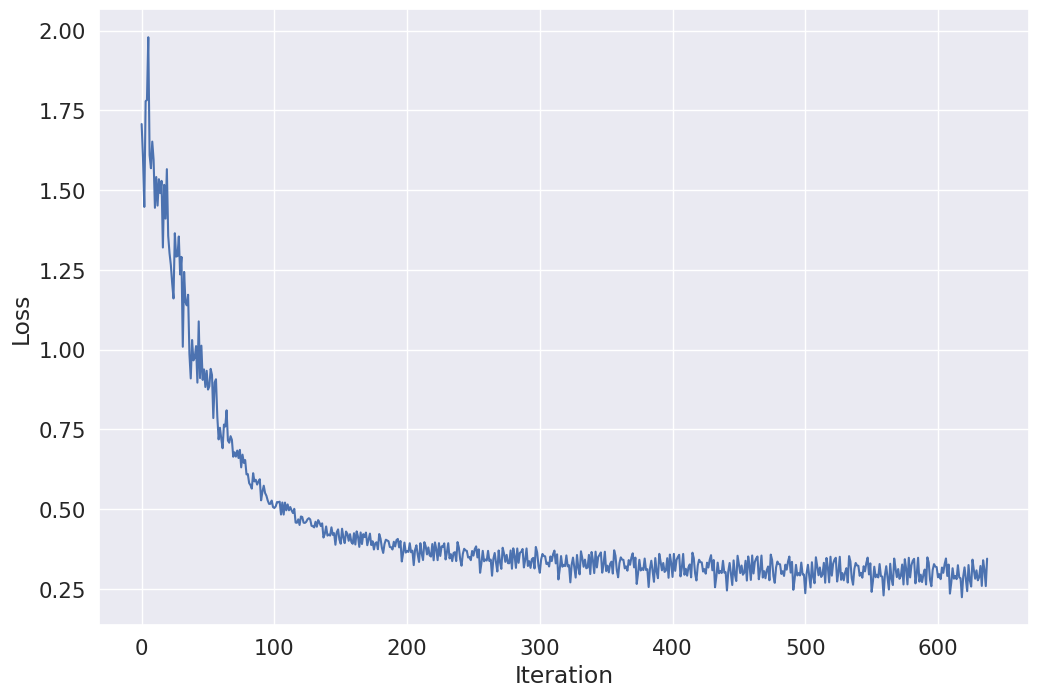

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

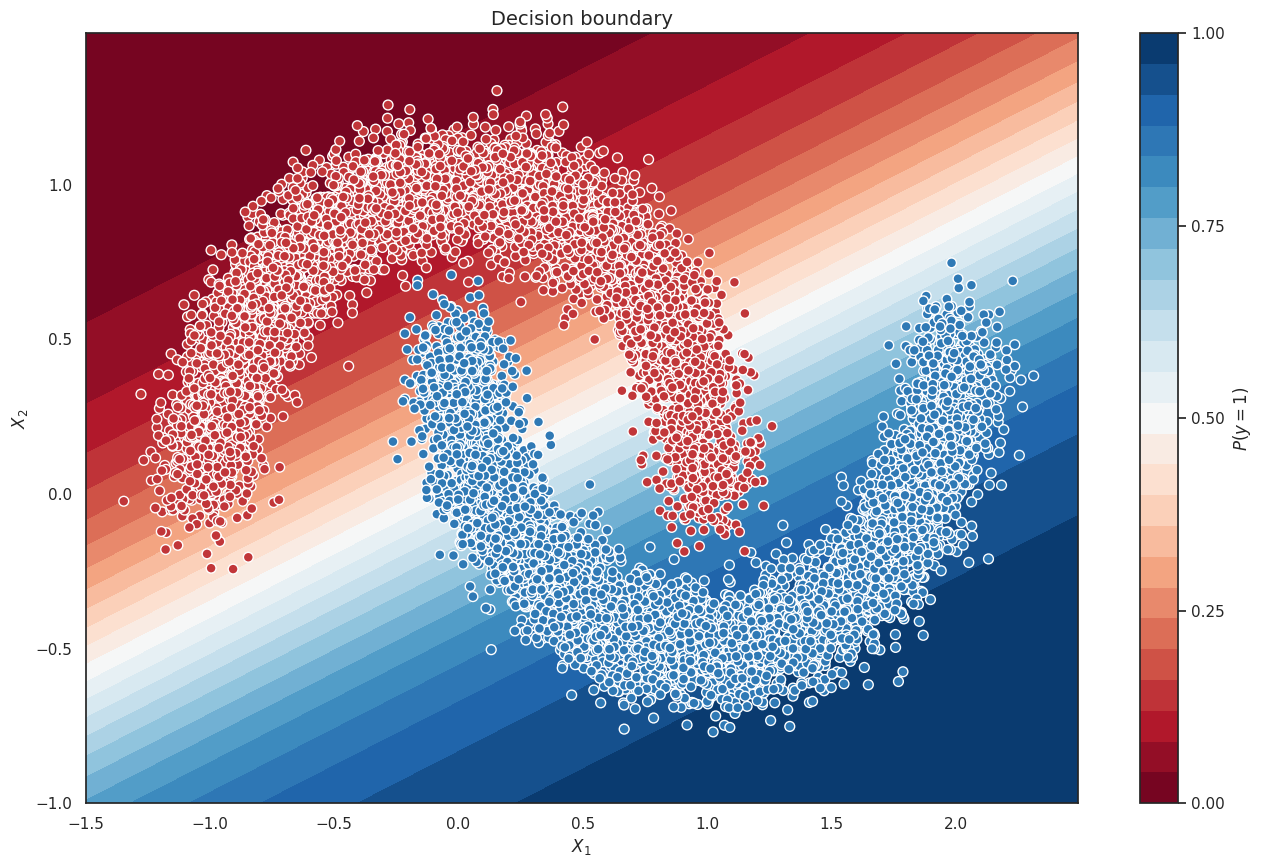

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Task: Implement predict and calculate accuracy on test.
---



In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

val_preds = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(y_val, val_preds)

print(f"Accuracy on validation set: {accuracy}")

Accuracy on validation set: 0.8732


**Question 3**

What `accuracy` do you get after training?

**Answer:** 0.8732

# Part 2. MNIST dataset
The MNIST dataset contains handwritten digits. Let's load the dataset and create DataLoaders. An example can be found in the Fully Connected Neural Networks Workshop.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(val_dataset, batch_size=128)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 534kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


## Part 2.1. Fully Connected Neural Networks
First, we'll solve MNIST using a fully connected neural network.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Task. Simple fully connected neural network

Create a fully connected neural network using the Sequential class. The network consists of:
* Matrix flattening into a vector (nn.Flatten);
* Two hidden layers of 128 neurons with nn.ELU activation;
* An output layer with 10 neurons.

Set the training loss (cross-entropy).


In [ ]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128), # MNIST is 28x28
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Let's take a look at the code below, which will suit 90% of future tasks.

```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Task: Complete the training cycle.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8806
Loader: valid. Accuracy: 0.9205
Epoch: 2
Loader: train. Accuracy: 0.9421333333333334
Loader: valid. Accuracy: 0.953
Epoch: 3
Loader: train. Accuracy: 0.9598833333333333
Loader: valid. Accuracy: 0.9608
Epoch: 4
Loader: train. Accuracy: 0.9681333333333333
Loader: valid. Accuracy: 0.9659
Epoch: 5
Loader: train. Accuracy: 0.9744833333333334
Loader: valid. Accuracy: 0.9671
Epoch: 6
Loader: train. Accuracy: 0.9788333333333333
Loader: valid. Accuracy: 0.968
Epoch: 7
Loader: train. Accuracy: 0.9819333333333333
Loader: valid. Accuracy: 0.9638
Epoch: 8
Loader: train. Accuracy: 0.9844666666666667
Loader: valid. Accuracy: 0.9679
Epoch: 9
Loader: train. Accuracy: 0.9860166666666667
Loader: valid. Accuracy: 0.968
Epoch: 10
Loader: train. Accuracy: 0.9852833333333333
Loader: valid. Accuracy: 0.9686


### Task. Test different activation functions.
Try different activation functions. For each activation function, calculate the validation accuracy array. It is better to implement this as a function that takes activation as input and receives an array of accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    accuracy = {"train": [], "valid": []}
    max_epochs = 10

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

### Accuracy
Let's plot the accuracy/epoch graph for each activation function.

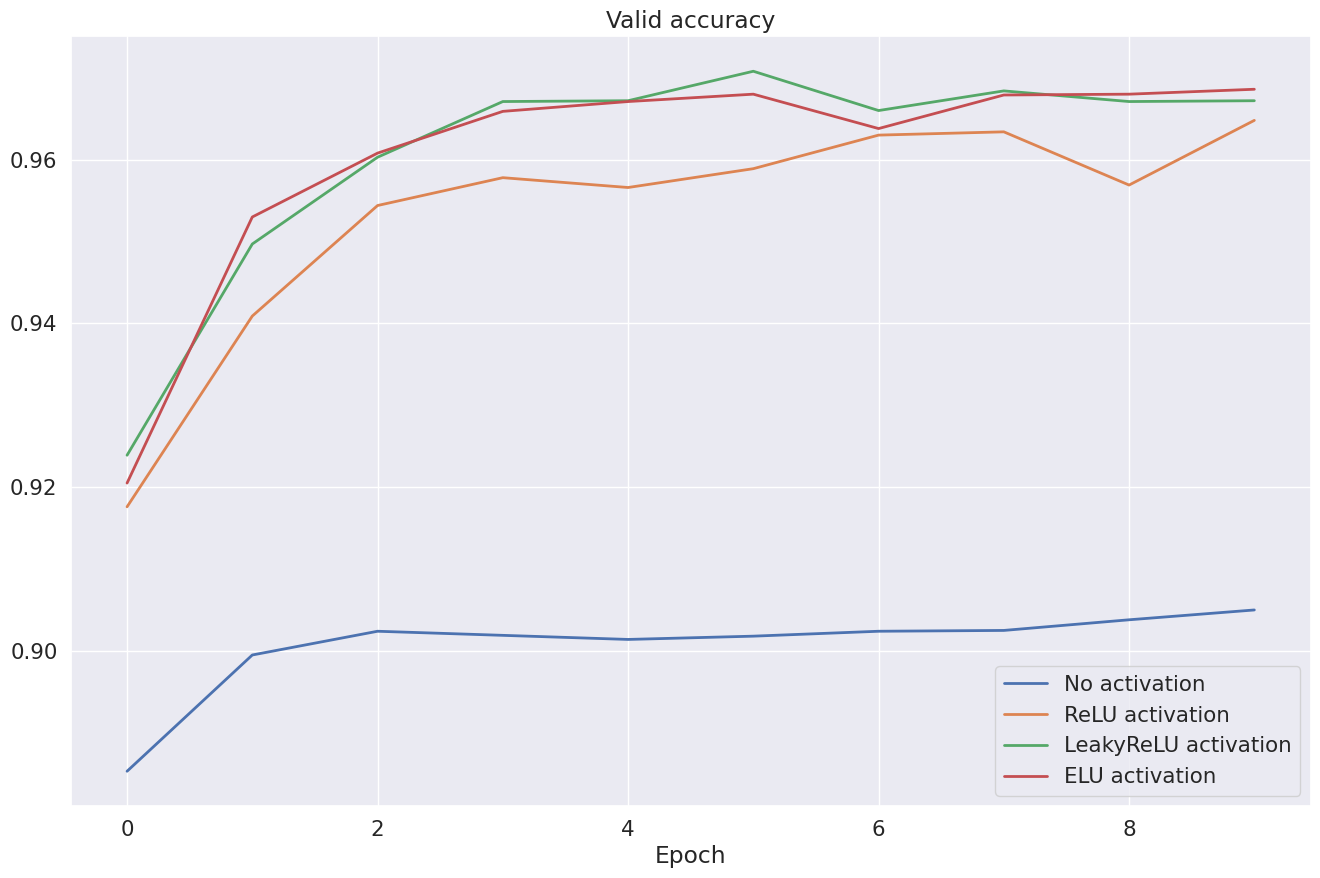

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

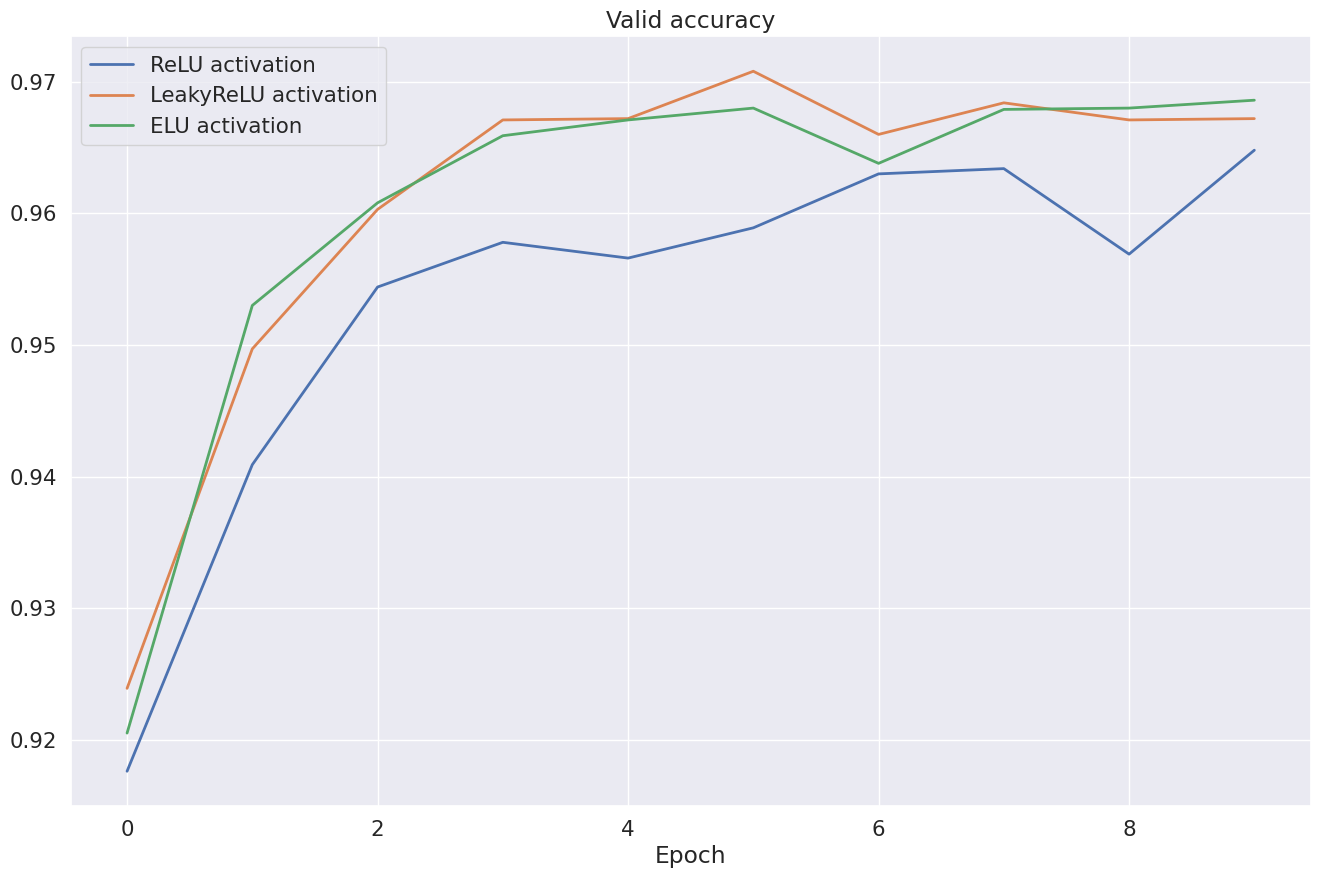

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Question 4.** Which activation showed the highest `accuracy` by the end of the training?

**Answer:**

## Part 2.2 Convolutional Neural Networks
---



### Kernels
First, let's work a little with the concept of a convolution kernel itself.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2025-10-14 08:02:27--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   164KB/s    in 0.3s    

2025-10-14 08:02:28 (164 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



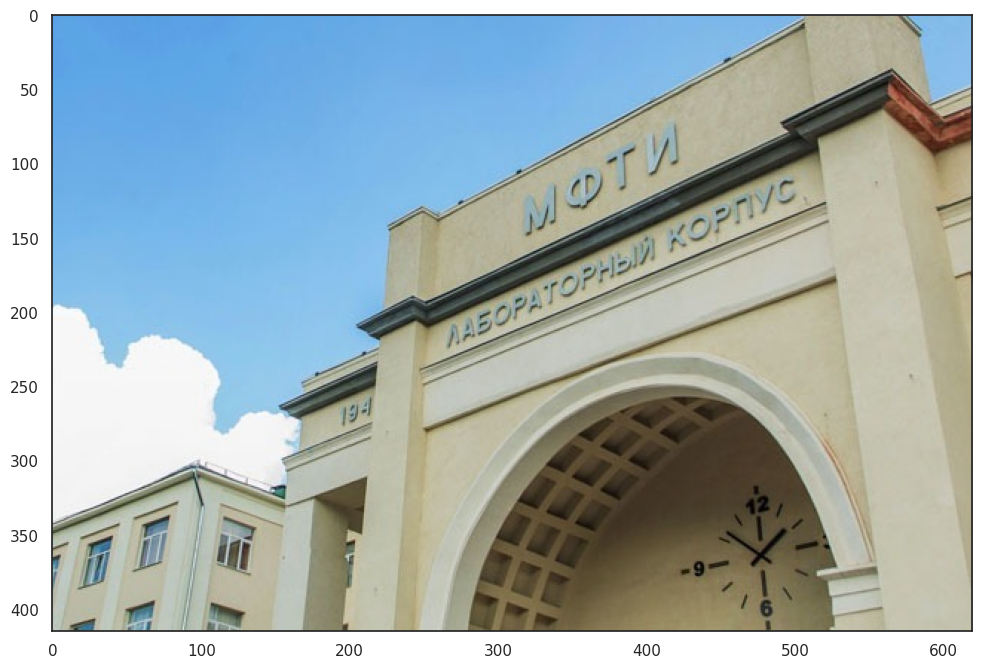

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Try to see how different convolutions affect the photo. For example, try

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```


In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

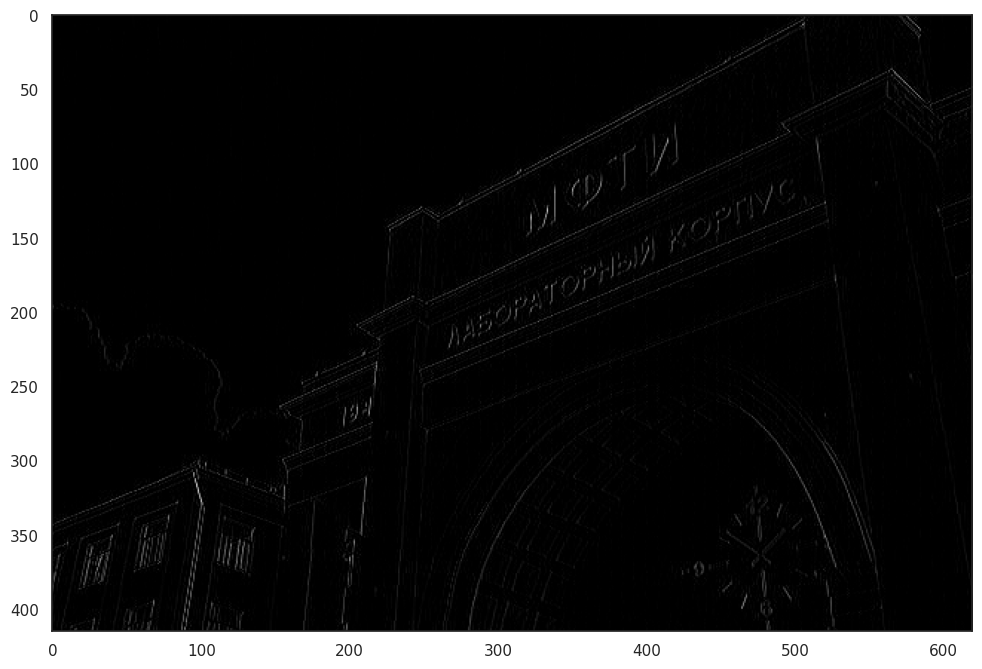

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Question 5.** How can you describe the actions of the kernels above? Match each letter with a number.

1) Blur

2) Sharpen

3) Identity transformation

4) Vertical edge detection

5) Horizontal edge detection

6) Edge detection

**Answer:**

A) Identity transformation B) Vertical edge detection C) Horizontal edge detection D) Edge detection E) Sharpen F) Blur

### Task: Implement LeNet

If we make the parameters of the convolutions trainable, we can achieve good results for computer vision tasks. Implement the LeNet architecture proposed back in 1998!
This time, use a modular structure (without the help of the Sequential class).

Our neural network will consist of
* A 3x3 convolution (1 map at the input, 6 at the output) with ReLU activation;
* A 2x2 MaxPooling;
* A 3x3 convolution (6 maps at the input, 16 at the output) with ReLU activation;
* A 2x2 MaxPooling;
* Flattening (nn.Flatten);
* A fully connected layer with 120 neurons and ReLU activation;
* A fully connected layer with 84 neurons and ReLU activation;
* An output layer of 10 neurons.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Task: Train a CNN
Use the training code you wrote for the fully connected neural network.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8829166666666667
Loader: valid. Accuracy: 0.9651
Epoch: 2
Loader: train. Accuracy: 0.9679333333333333
Loader: valid. Accuracy: 0.9717
Epoch: 3
Loader: train. Accuracy: 0.9774833333333334
Loader: valid. Accuracy: 0.978
Epoch: 4
Loader: train. Accuracy: 0.9826166666666667
Loader: valid. Accuracy: 0.9825
Epoch: 5
Loader: train. Accuracy: 0.9860666666666666
Loader: valid. Accuracy: 0.984
Epoch: 6
Loader: train. Accuracy: 0.9885333333333334
Loader: valid. Accuracy: 0.9855
Epoch: 7
Loader: train. Accuracy: 0.9909166666666667
Loader: valid. Accuracy: 0.9855
Epoch: 8
Loader: train. Accuracy: 0.9924666666666667
Loader: valid. Accuracy: 0.985
Epoch: 9
Loader: train. Accuracy: 0.9937333333333334
Loader: valid. Accuracy: 0.9852
Epoch: 10
Loader: train. Accuracy: 0.9946333333333334
Loader: valid. Accuracy: 0.986


In [ ]:
lenet_accuracy = accuracy["valid"]


Let's compare with the previous point

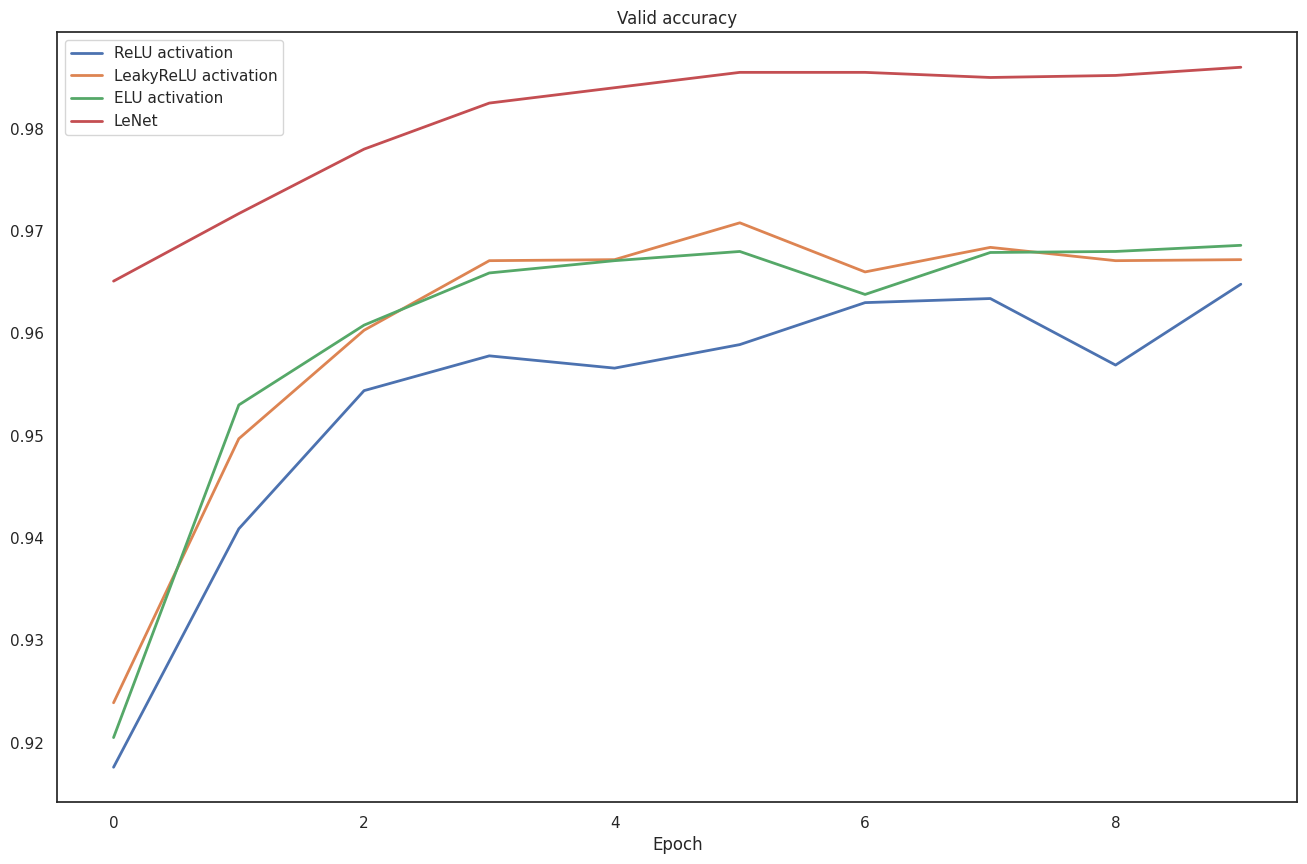

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Question 6**
What is the `accuracy` obtained after training with an accuracy of two decimal places?

**Answer:**

In [ ]:
final_accuracy = accuracy["valid"][-1]
print(f"{final_accuracy:.2f}")

0.99
